# MAESTRIA INTELIGENCIA  ARTIFICIAL

---

INTEGRANTES:
- Edwin Montenegro
- Galo Travez

## LABORATORIO 4
### OBJETIVO
El objetivo general de este laboratorio es desarrollar y entrenar un modelo de Word2Vec utilizando redes neuronales convolucionales (CNN) en este caso fue implementado con PyTorch Lightning para aprender representaciones vectoriales de palabras a partir del texto "Cien años de soledad" de Gabriel García Márquez.

### INDICE
- Configuración de Hiperparámetros
- Preprocesamiento de Texto
- Creación del Vocabulario:
- Generación de Ventanas de Contexto
- Definición del Dataset y DataLoader
- Definición del Modelo CNN en PyTorch Lightning
- Evaluación y Resultados


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from scipy.spatial import distance
import matplotlib.pyplot as plt
import numpy as np


### Configuración de Hiperparámetros
Configuración de los hiperparámetros necesarios para el modelo

In [ ]:
# Configuración de Hiperparámetros
EMBEDDING_SIZE = 100  # Tamaño del vector de embeddings
KERNEL_SIZE = 3  #Tamaño del kernel para la convolución
BATCH_SIZE = 64  #Tamaño del lote para el entrenamiento
LEARNING_RATE = 0.00001   #Tasa de aprendizaje para el optimizador
EPOCHS = 50  #Número de épocas para entrenar el modelo
DROPOUT_RATE = 0.3  #Tasa de dropout para regularización
WEIGHT_DECAY = 1e-5  #Factor de decaimiento del peso para regularización
PATIENCE = 5  #Número de épocas sin mejora para el criterio de parada temprana

#### Preprocesamiento de Texto y Creación del Vocabulario

-  Utilizamos  RegexpTokenizer para dividir el texto en palabras, eliminando signos de puntuación
- Se eliminan las palabras comunes utilizando la lista de stopwords
- Aplicamos el SnowballStemmer para reducir las palabras a su raíz morfológica.

In [ ]:
# Procesamiento del texto y creación del vocabulario
ss = SnowballStemmer('spanish')
sw = stopwords.words('spanish')
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
# Cargamos el texto
text = open('/home/emontenegrob/Labs_NLP/data/gabriel_garcia_marquez_cien_annos_soledad.txt', 'r').read().lower()


In [ ]:
def split_tokens(text):
    tokens = tokenizer.tokenize(text)
    tokens = [w for w in tokens if w not in sw]
    return tokens

In [ ]:
tokens = split_tokens(text)

In [ ]:
tokens[:10]

['gabriel',
 'garcía',
 'márquez',
 'cien',
 'años',
 'soledad',
 'editado',
 'ediciones',
 'cueva',
 'j']

- Creamos un vocabulario con palabras que aparecen más de una vez, utilizando Counter para contar la frecuencia de cada token. Esto asegura que solo se mantengan las palabras relevantes.

In [ ]:
counts = Counter(tokens)
counts_more_than_1 = {k: v for k, v in counts.items() if v > 1}
vocab = list(counts_more_than_1.keys())
itot = dict(enumerate(vocab))
ttoi = {v: k for k, v in itot.items()}

tokens_more_than_1 = [w for w in tokens if w in vocab]


In [ ]:
counts

Counter({'gabriel': 184,
         'garcía': 173,
         'márquez': 241,
         'cien': 182,
         'años': 357,
         'soledad': 217,
         'editado': 1,
         'ediciones': 2,
         'cueva': 2,
         'j': 10,
         'omi': 1,
         'ascot': 1,
         'maría': 4,
         'luisa': 1,
         'elio': 1,
         'después': 229,
         'frente': 77,
         'pelotón': 23,
         'fusilamiento': 24,
         'coronel': 312,
         'aureliano': 794,
         'buendía': 406,
         'recordar': 22,
         'aquella': 109,
         'tarde': 149,
         'remota': 12,
         'padre': 117,
         'llevó': 63,
         'conocer': 28,
         'hielo': 29,
         'macondo': 180,
         'entonces': 272,
         'aldea': 33,
         'veinte': 32,
         'casas': 35,
         'barro': 7,
         'cañabrava': 2,
         'construidas': 2,
         'orilla': 4,
         'río': 18,
         'aguas': 8,
         'diáfanas': 2,
         'precipitaban': 

###  Ventana de Contexto y Preparación de Datos
- Generamos ventanas de palabras alrededor de cada palabra objetivo dentro de un tamaño de ventana definido (en este caso, 4)

In [ ]:
def window(tokens, win):
    output = []
    for i, w in enumerate(tokens):
        target = ttoi[w]
        window = [tokens[i + j] for j in range(-win, win + 1, 1) if (i + j >= 0) & (i + j < len(tokens)) & (j != 0)]
        output += [(target, ttoi[j]) for j in window]
    return output

data_windowed = window(tokens_more_than_1, win=4)

In [ ]:
data_windowed

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 8),
 (6, 1),
 (6, 9),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 8),
 (7, 1),
 (7, 9),
 (7, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 1),
 (8, 9),
 (8, 3),
 (8, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 3),
 (1, 4),
 (1, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 1),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 0),
 (3, 7),
 (3, 8),
 (3, 1),
 (3, 9),
 (3, 4),
 (3, 5),
 (3, 0),
 (3, 1),
 (4, 8),
 (4, 1),
 (4, 9),
 (4, 3),
 (4, 5),
 (4, 0),
 (4, 1),
 (4, 2),
 (5, 1),
 (5, 9),
 (5, 3),
 (5, 4),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 4),
 (0, 9),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 1),
 (0, 2),
 (0, 4),
 (0, 10),
 (1, 3),


### Definición del Dataset
- La clase TextDataset se crea para manejar estos pares de datos, generando representaciones one-hot para las palabras de entrada y salida.

In [ ]:
class TextDataset(Dataset):
    def __init__(self, data_windowed, vocab_size):
        self.data = data_windowed
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x0, y = self.data[idx]
        x = F.one_hot(torch.tensor(x0), num_classes=self.vocab_size)
        return x, y

### Definición del Modelo CNN

In [ ]:
# Definición del modelo con CNN en PyTorch Lightning
class Word2VecCNN(pl.LightningModule):
    def __init__(self, vocab_size, embedding_size, kernel_size=3, dropout_rate=0.3):
        super(Word2VecCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.conv = nn.Conv1d(embedding_size, embedding_size, kernel_size, padding=kernel_size//2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(embedding_size, vocab_size)

    def forward(self, input):
        x = self.embedding(input.to(torch.int64))
        x = x.permute(0, 2, 1)  # Reordenar para que Conv1d funcione correctamente (Batch, Channel, Seq)
        x = F.relu(self.conv(x))
        x = torch.mean(x, dim=2)  # Pooling global para obtener el vector final
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

    def training_step(self, batch, batch_idx):
        context, center = batch
        logits = self.forward(context)
        loss = F.cross_entropy(logits, center)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


In [ ]:
# Preparación de datos
vocab_size = len(vocab)
dataset = TextDataset(data_windowed, vocab_size)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=4)


In [ ]:
# Configuración del logger y callbacks
logger = CSVLogger("logs", name="word2vec_cnn")
early_stop_callback = EarlyStopping(monitor="train_loss", patience=PATIENCE, mode="min")
checkpoint_callback = ModelCheckpoint(dirpath="checkpoints", save_top_k=1, monitor="train_loss", mode="min")

# Entrenamiento del modelo
model = Word2VecCNN(vocab_size, EMBEDDING_SIZE, KERNEL_SIZE, DROPOUT_RATE)
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator="auto", devices=1 if torch.cuda.is_available() else 0, # use accelerator and devices instead of gpus
                     logger=logger, callbacks=[early_stop_callback, checkpoint_callback])


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Explicaciòn del modelo implementado
- Entrada: Un lote de palabras de contexto, representadas como índices en el vocabulario.
- Embedding Layer: Cada índice de palabra se convierte en un vector de tamaño embedding_dim=100.
- Conv1d Layer: La secuencia de embeddings se pasa a través de la capa convolucional, que extrae características locales (relaciones contextuales) en la secuencia.
- Dropout Layer: Se aplica dropout a las salidas de la capa convolucional para evitar el sobreajuste.
- Linear Layer: Esta es una capa densa que mapea la salida de la capa convolucional (después del dropout) a una representación del tamaño del vocabulario.

In [ ]:
model

Word2VecCNN(
  (embedding): Embedding(7406, 100)
  (conv): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=100, out_features=7406, bias=True)
)

###Entrenamiento del Modelo
- El modelo se entrena utilizando el optimizador AdamW con los hiperparámetros configurados al inicio del programa

In [ ]:
trainer.fit(model, dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | embedding | Embedding | 740 K  | train
1 | conv      | Conv1d    | 30.1 K | train
2 | dropout   | Dropout   | 0      | train
3 | fc        | Linear    | 748 K  | train
------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.075     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


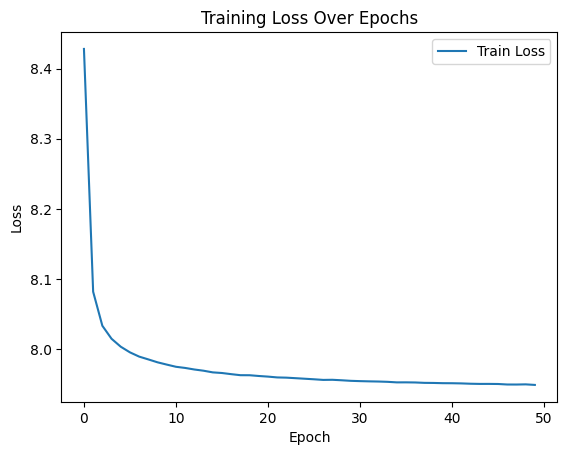

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar los datos de métricas desde el archivo CSV generado por PyTorch Lightning
metrics = np.genfromtxt("/content/logs/word2vec_cnn/version_1/metrics.csv", delimiter=',', names=True)

# Filtramos solo las filas que corresponden al final de cada epoch (último step de cada epoch)
epoch_indices = np.where(metrics['epoch'] == np.floor(metrics['epoch']))[0]

# Graficar la pérdida en función de las épocas
plt.plot(metrics['epoch'][epoch_indices], metrics['train_loss'][epoch_indices], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Over Epochs')
plt.show()


### Evaluación y obtención de palabras similares
-  Los pesos de la última capa densa (fc.weight) se extraen como vectores de palabras embeddings.
- Se utiliza la distancia coseno para calcular similitudes entre las palabras.
- Para cada palabra en un conjunto de prueba, se busca en la matriz de distancias las palabras más cercanas, basándose en la similitud de los vectores.

In [ ]:
# Evaluación y obtención de palabras similares
wordvecs = model.fc.weight.cpu().detach().numpy()

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    idx = ttoi[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k + 1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, itot[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')
tokens_test = ['aureliano', 'coronel', 'macondo', 'casa', 'pueblo', 'melquíades', 'arcadio', 'úrsula','casa']
tokens_test_valid = [word for word in tokens_test if word in ttoi]
for word in tokens_test_valid:
    print(word, [t[1] for t in get_k_similar_words(word, dmat, k=10)], "\n")



aureliano ['úrsula', 'coronel', 'entonces', 'josé', 'arcadio', 'dijo', 'casa', 'amaranta', 'segundo', 'después'] 

coronel ['aureliano', 'entonces', 'úrsula', 'josé', 'segundo', 'casa', 'arcadio', 'amaranta', 'años', 'después'] 

macondo ['sino', 'garcía', 'dos', 'fernanda', 'noche', 'si', 'mientras', 'tarde', 'josé', 'casa'] 

casa ['josé', 'buendía', 'arcadio', 'tiempo', 'segundo', 'dijo', 'si', 'después', 'úrsula', 'aureliano'] 

pueblo ['casa', 'buendía', 'josé', 'arcadio', 'sólo', 'dijo', 'amaranta', 'entonces', 'vez', 'único'] 

melquíades ['garcía', 'mujer', 'día', 'ser', 'aquel', 'cuarto', 'tarde', 'sino', 'hombre', 'volvió'] 

arcadio ['josé', 'buendía', 'úrsula', 'casa', 'amaranta', 'tan', 'tiempo', 'aureliano', 'dijo', 'después'] 

úrsula ['aureliano', 'josé', 'arcadio', 'amaranta', 'buendía', 'segundo', 'entonces', 'tan', 'después', 'casa'] 

casa ['josé', 'buendía', 'arcadio', 'tiempo', 'segundo', 'dijo', 'si', 'después', 'úrsula', 'aureliano'] 



Se agrega la gráfica de pérdida con la red neuronal simple para realizar una mejor comparación.

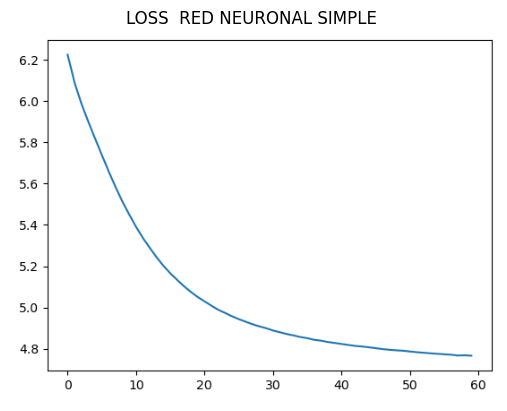

In [206]:
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Leer y mostrar la imagen
img = mpimg.imread('/home/emontenegrob/Labs_NLP/data/lossNN.png')  # Cambia 'nombre_de_tu_imagen.jpg' por el nombre de tu archivo
plt.imshow(img)

# Añadir el título
plt.title('LOSS  RED NEURONAL SIMPLE ')  # Cambia 'Mi Imagen Subida' por el título que prefieras
plt.axis('off')  # Opcional: Oculta los ejes
plt.show()

### CONCLUSIONES
- Estos datos representan las relaciones contextuales que se encuentran en "Cien años de soledad" donde se capturan  las asociaciones semánticas y narrativas entre las palabras del texto.

- La red neuronal  CNNS  aprendio  a representar palabras en un espacio vectorial donde palabras con contextos similares estén más cerca unas de otras, reflejando tanto el estilo literario único de Márquez como la estructura narrativa del libro.

- Las listas de palabras contextuales generadas por la CNN son coherentes en términos de mantener relaciones semánticas entre las palabras (como "aureliano" con "úrsula", "coronel", "arcadio",  y "macondo" con términos relacionados como "aldea", "casa").

- A pesar de que la CNN tiene una pérdida de entrenamiento final más alta que
la red neuronal simple, no significa necesariamente que sea un modelo peor. De hecho, es posible que la CNN esté capturando mejor las relaciones contextuales complejas debido a su capacidad de modelado superior, y el uso de regularización (como Dropout) puede estar protegiendo contra el sobreajuste, lo que es beneficioso para la generalización en conjuntos de datos no vistos

# MODELO  ENTRENADO CON STEAMMING
 Por otra parte se volvio hacer el entrenaminto con  stemming  con el fin de  observar como se comparta el modelo con una red neuronal convulucional

In [ ]:
# Configuración de Hiperparámetros
EMBEDDING_SIZE = 100
KERNEL_SIZE = 3
BATCH_SIZE = 64
LEARNING_RATE = 0.00005  # Reduce la tasa de aprendizaje
EPOCHS = 20
DROPOUT_RATE = 0.3
PATIENCE = 5

En el preprocesamiento, se añadió la línea `tokens = [ss.stem(w) for w in tokens]`, que aplica stemming a cada palabra después de la tokenización y la eliminación de stopwords.

El resto del código se mantiene similar en cuanto a la definición del modelo CNN y la preparación de los datos, con la excepción de que ahora trabaja con palabras que han pasado por un proceso de stemming.

In [ ]:
def split_tokens(text):
    tokens = tokenizer.tokenize(text)
    tokens = [w for w in tokens if w not in sw]
    tokens = [ss.stem(w) for w in tokens]  # Aplicar stemming
    return tokens

In [ ]:
tokens = split_tokens(text)

In [ ]:
tokens[:20]

['gabriel',
 'garc',
 'marquez',
 'cien',
 'años',
 'soled',
 'edit',
 'edicion',
 'cuev',
 'j',
 'omi',
 'garc',
 'ascot',
 'mar',
 'luis',
 'eli',
 'cien',
 'años',
 'soled',
 'gabriel']

In [ ]:
counts = Counter(tokens)
counts_more_than_1 = {k: v for k, v in counts.items() if v > 1}
vocab = list(counts_more_than_1.keys())
itot = dict(enumerate(vocab))
ttoi = {v: k for k, v in itot.items()}

tokens_more_than_1 = [w for w in tokens if w in vocab]

In [ ]:
def window(tokens, win=2):
    output = []
    for i, w in enumerate(tokens):
        target = ttoi[w]
        window = [tokens[i + j] for j in range(-win, win + 1, 1) if (i + j >= 0) & (i + j < len(tokens)) & (j != 0)]
        output += [(target, ttoi[j]) for j in window]
    return output

data_windowed = window(tokens_more_than_1, win=4)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, data_windowed, vocab_size):
        self.data = data_windowed
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x0, y = self.data[idx]
        x = F.one_hot(torch.tensor(x0), num_classes=self.vocab_size)
        return x, y

### Definición del Modelo CNN  con steamming

In [ ]:
# Definición del modelo con CNN en PyTorch Lightning
class Word2VecCNN(pl.LightningModule):
    def __init__(self, vocab_size, embedding_size, kernel_size=3, dropout_rate=0.3):
        super(Word2VecCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.conv = nn.Conv1d(embedding_size, embedding_size, kernel_size, padding=kernel_size//2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(embedding_size, vocab_size)

    def forward(self, input):
        x = self.embedding(input.to(torch.int64))
        x = x.permute(0, 2, 1)  # Reordenar para que Conv1d funcione correctamente (Batch, Channel, Seq)
        x = F.relu(self.conv(x))
        x = torch.mean(x, dim=2)  # Pooling global para obtener el vector final
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

    def training_step(self, batch, batch_idx):
        context, center = batch
        logits = self.forward(context)
        loss = F.cross_entropy(logits, center)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=LEARNING_RATE)


In [ ]:
# Preparación de datos
vocab_size = len(vocab)
dataset = TextDataset(data_windowed, vocab_size)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


In [ ]:
# Configuración del logger y callbacks
logger = CSVLogger("logs2", name="word2vec_cnn_steamming")
early_stop_callback = EarlyStopping(monitor="train_loss", patience=PATIENCE, mode="min")
checkpoint_callback = ModelCheckpoint(dirpath="checkpoints", save_top_k=1, monitor="train_loss", mode="min")

# Entrenamiento del modelo
model = Word2VecCNN(vocab_size, EMBEDDING_SIZE, KERNEL_SIZE, DROPOUT_RATE)
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator="auto", devices=1 if torch.cuda.is_available() else 0,
                     logger=logger, callbacks=[early_stop_callback, checkpoint_callback])



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


###Entrenamiento del Modelo

In [ ]:
trainer.fit(model, dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | embedding | Embedding | 485 K  | train
1 | conv      | Conv1d    | 30.1 K | train
2 | dropout   | Dropout   | 0      | train
3 | fc        | Linear    | 490 K  | train
------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.024     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to 

Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


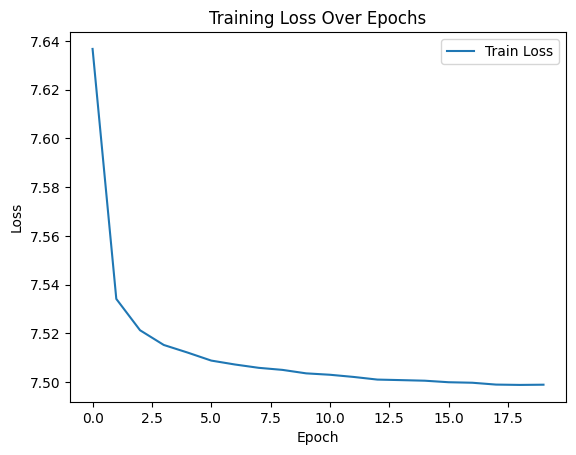

In [ ]:
# Visualización de la pérdida
metrics = np.genfromtxt("/content/logs2/word2vec_cnn_steamming/version_1/metrics.csv", delimiter=',', names=True)
plt.plot(metrics['epoch'], metrics['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Over Epochs')
plt.show()

### Evaluación y obtención de palabras similares

In [ ]:
# Aplicar stemming a las palabras de prueba
tokens_test = ['aureliano', 'coronel', 'macondo', 'casa', 'pueblo', 'melquíades', 'arcadio', 'úrsula', 'años']
tokens_test_stemmed = [ss.stem(w) for w in tokens_test]

# Validar si las palabras de prueba con stemming están en el vocabulario
tokens_test_valid = [word for word in tokens_test_stemmed if word in ttoi]

# Evaluación y obtención de palabras similares
wordvecs = model.fc.weight.cpu().detach().numpy()

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    idx = ttoi[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k + 1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, itot[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')

# Imprimir palabras válidas en el vocabulario y sus similares
for word in tokens_test_valid:
    print(word, [t[1] for t in get_k_similar_words(word, dmat, k=10)], "\n")

# Mostrar palabras que no están en el vocabulario
for word in tokens_test_stemmed:
    if word not in ttoi:
        print(f"'{word}' no se encuentra en el vocabulario.")

aurelian ['arcadi', 'cas', 'ursul', 'jos', 'tiemp', 'buend', 'sol', 'llev', 'coronel', 'segund'] 

coronel ['aurelian', 'jos', 'arcadi', 'buend', 'ursul', 'noch', 'tiemp', 'cas', 'pas', 'años'] 

macond ['buend', 'ursul', 'tiemp', 'jos', 'coronel', 'tan', 'cas', 'aurelian', 'arcadi', 'qued'] 

cas ['ursul', 'aurelian', 'segund', 'buend', 'jos', 'arcadi', 'tiemp', 'entonc', 'amarant', 'tan'] 

puebl ['sin', 'amarant', 'mes', 'tan', 'jos', 'lleg', 'pens', 'pas', 'tiemp', 'vez'] 

melquiad ['dec', 'sal', 'dij', 'tan', 'buend', 'marquez', 'puebl', 'sab', 'mes', 'ursul'] 

arcadi ['ursul', 'aurelian', 'segund', 'jos', 'cas', 'buend', 'tan', 'dij', 'tiemp', 'coronel'] 

ursul ['arcadi', 'buend', 'cas', 'aurelian', 'jos', 'segund', 'tiemp', 'tan', 'dij', 'sol'] 

años ['coronel', 'soled', 'ursul', 'arcadi', 'buend', 'noch', 'cas', 'primer', 'jos', 'llev'] 



### CONCLUSIONES
- Se pudo corroborar lo visto previamente en las clases, donde el stemming tiene varios objetivos, como ayudar a normalizar el texto al reducir las palabras a sus raíces comunes. También contribuye a la reducción de la dimensionalidad del vocabulario, convirtiéndose así en un modelo más manejable y menos propenso a sobreajustarse.

- Aunque se pierden algunos detalles finos del significado al aplicar stemming, los resultados indican que el modelo todavía logra capturar un contexto relevante y significativo. Las palabras en las listas de contexto, como "ursul" (de "úrsula") con "arcadi" (de "arcadio"), "buend" (de "buendía"), "sol", "tiemp" (de "tiempo"),, muestran relaciones coherentes que reflejan bien el contenido del libro "Cien años de soledad".

-  Es importante recalcar  que el uso de  stemming en el preprocesamiento antes de entrenar un modelo CNN  puede ser beneficioso para reducir la complejidad del vocabulario y mejorar la eficiencia del entrenamiento, especialmente en lenguajes ricos en morfología como el español. Sin embargo, este enfoque puede no siempre llevar a una mejor reducción de la pérdida de entrenamiento, y podría resultar en la pérdida de información semántica importante que afecta la precisión del modelo en tareas donde los matices semánticos son cruciales.
- Desde mi punto de vista la decisión de usar stemming depende de la naturaleza del problema y el balance entre la eficiencia computacional y la preservación de la semántica contextual del texto.

